# 腦腫瘤分割 - 完整流程

本 notebook 包含從資料探索、資料清理到模型訓練和評估的完整流程。

## 目錄
1. **資料探索與清理** (來自 code.ipynb)
   - 資料集基本資訊
   - 標註分析
   - 問題圖片識別
   - 資料清理

2. **模型訓練流程** (來自 brain_tumor_complete.ipynb)
   - 環境設置
   - 資料增強
   - Dataset 和 DataLoader
   - U-Net 模型
   - 訓練與驗證
   - 測試與視覺化


# ⚡ 優化版本說明 (640x640)

本notebook已針對訓練速度進行優化，**保持圖像尺寸640x640**以維持準確度：

## 主要優化項目：

1. **混合精度訓練 (AMP)**: ⭐ 最重要的優化
   - 使用 FP16/FP32 自動混合精度
   - 加速: 2-3 倍
   - 記憶體節省: ~50%

2. **圖像尺寸**: **640×640** (保持不變)
   - 維持完整的影像細節
   - 確保最佳準確度

3. **模型參數**: 稍微優化
   - 特徵通道: [64,128,256,512] → [48,96,192,384]
   - 參數量: 31M → ~17M
   - 加速: ~1.3x

4. **資料增強**: 輕度簡化
   - 移除 ElasticTransform（最耗時）
   - 保留其他所有增強
   - 加速: ~1.2x

5. **DataLoader**: num_workers 4→2
   - 減少CPU負擔
   - 更穩定的訓練

## 預期效果：

| 項目 | 原始 | 優化640 | 加速比 |
|------|------|---------|--------|
| 圖像尺寸 | 640×640 | 640×640 | 1x (不變) |
| 混合精度 | FP32 | FP16/FP32 | ~2.5x |
| 模型參數 | 31M | 17M | ~1.3x |
| 資料增強 | 完整 | 輕度簡化 | ~1.2x |
| **總加速** | - | - | **~3.5-4x** |

## 訓練時間估算：

- **原始版本**: ~5 小時 / 25 epochs
- **優化版本**: ~1.2-1.5 小時 / 25 epochs
- **加速**: 約 3.5-4 倍

## 準確度影響：

- **預期 Dice Score 下降**: < 1%
- 由於保持圖像尺寸，準確度幾乎不受影響
- 混合精度訓練對準確度影響極小

💡 **這個版本在速度和準確度之間取得最佳平衡！**


---
# Part 1: 資料探索與清理
---

在訓練模型之前,我們需要先了解和清理資料集。


## Brain Tumor Image

### 01 Data input

In [1]:
import json
from collections import Counter

path = r".\train\_annotations.coco.json"
with open(path, "r", encoding="utf-8") as f:
    data = json.load(f)

print("images:", len(data.get("images", [])))
print("annotations:", len(data.get("annotations", [])))
print("categories:", len(data.get("categories", [])))
print("category names:", [c.get("name") for c in data.get("categories", [])])

# example: annotation counts per category id
cat_counts = Counter(a["category_id"] for a in data.get("annotations", []))
print("annotations per category id:", dict(cat_counts))

images: 1502
annotations: 1502
categories: 3
category names: ['Tumor', '0', '1']
annotations per category id: {1: 771, 2: 731}


成功匯入 PIL (Pillow)。將使用 PIL 進行圖片處理。
--- 程式碼開始 ---
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。
找到 1502 張圖片的紀錄。
找到 1501 張有標註的圖片。

--- 沒有標註的圖片 (Image IDs) ---
共 1 張:
[1380]

--- 有多個標註的圖片 (Image IDs) ---
共 1 張:
[1005]

--- 隨機顯示 3 張範例圖片 ---
將顯示 Image IDs: [650, 461, 999]

已儲存範例圖片至 annotation_analysis_samples_bw_mask.png
--- 程式碼執行完畢 ---


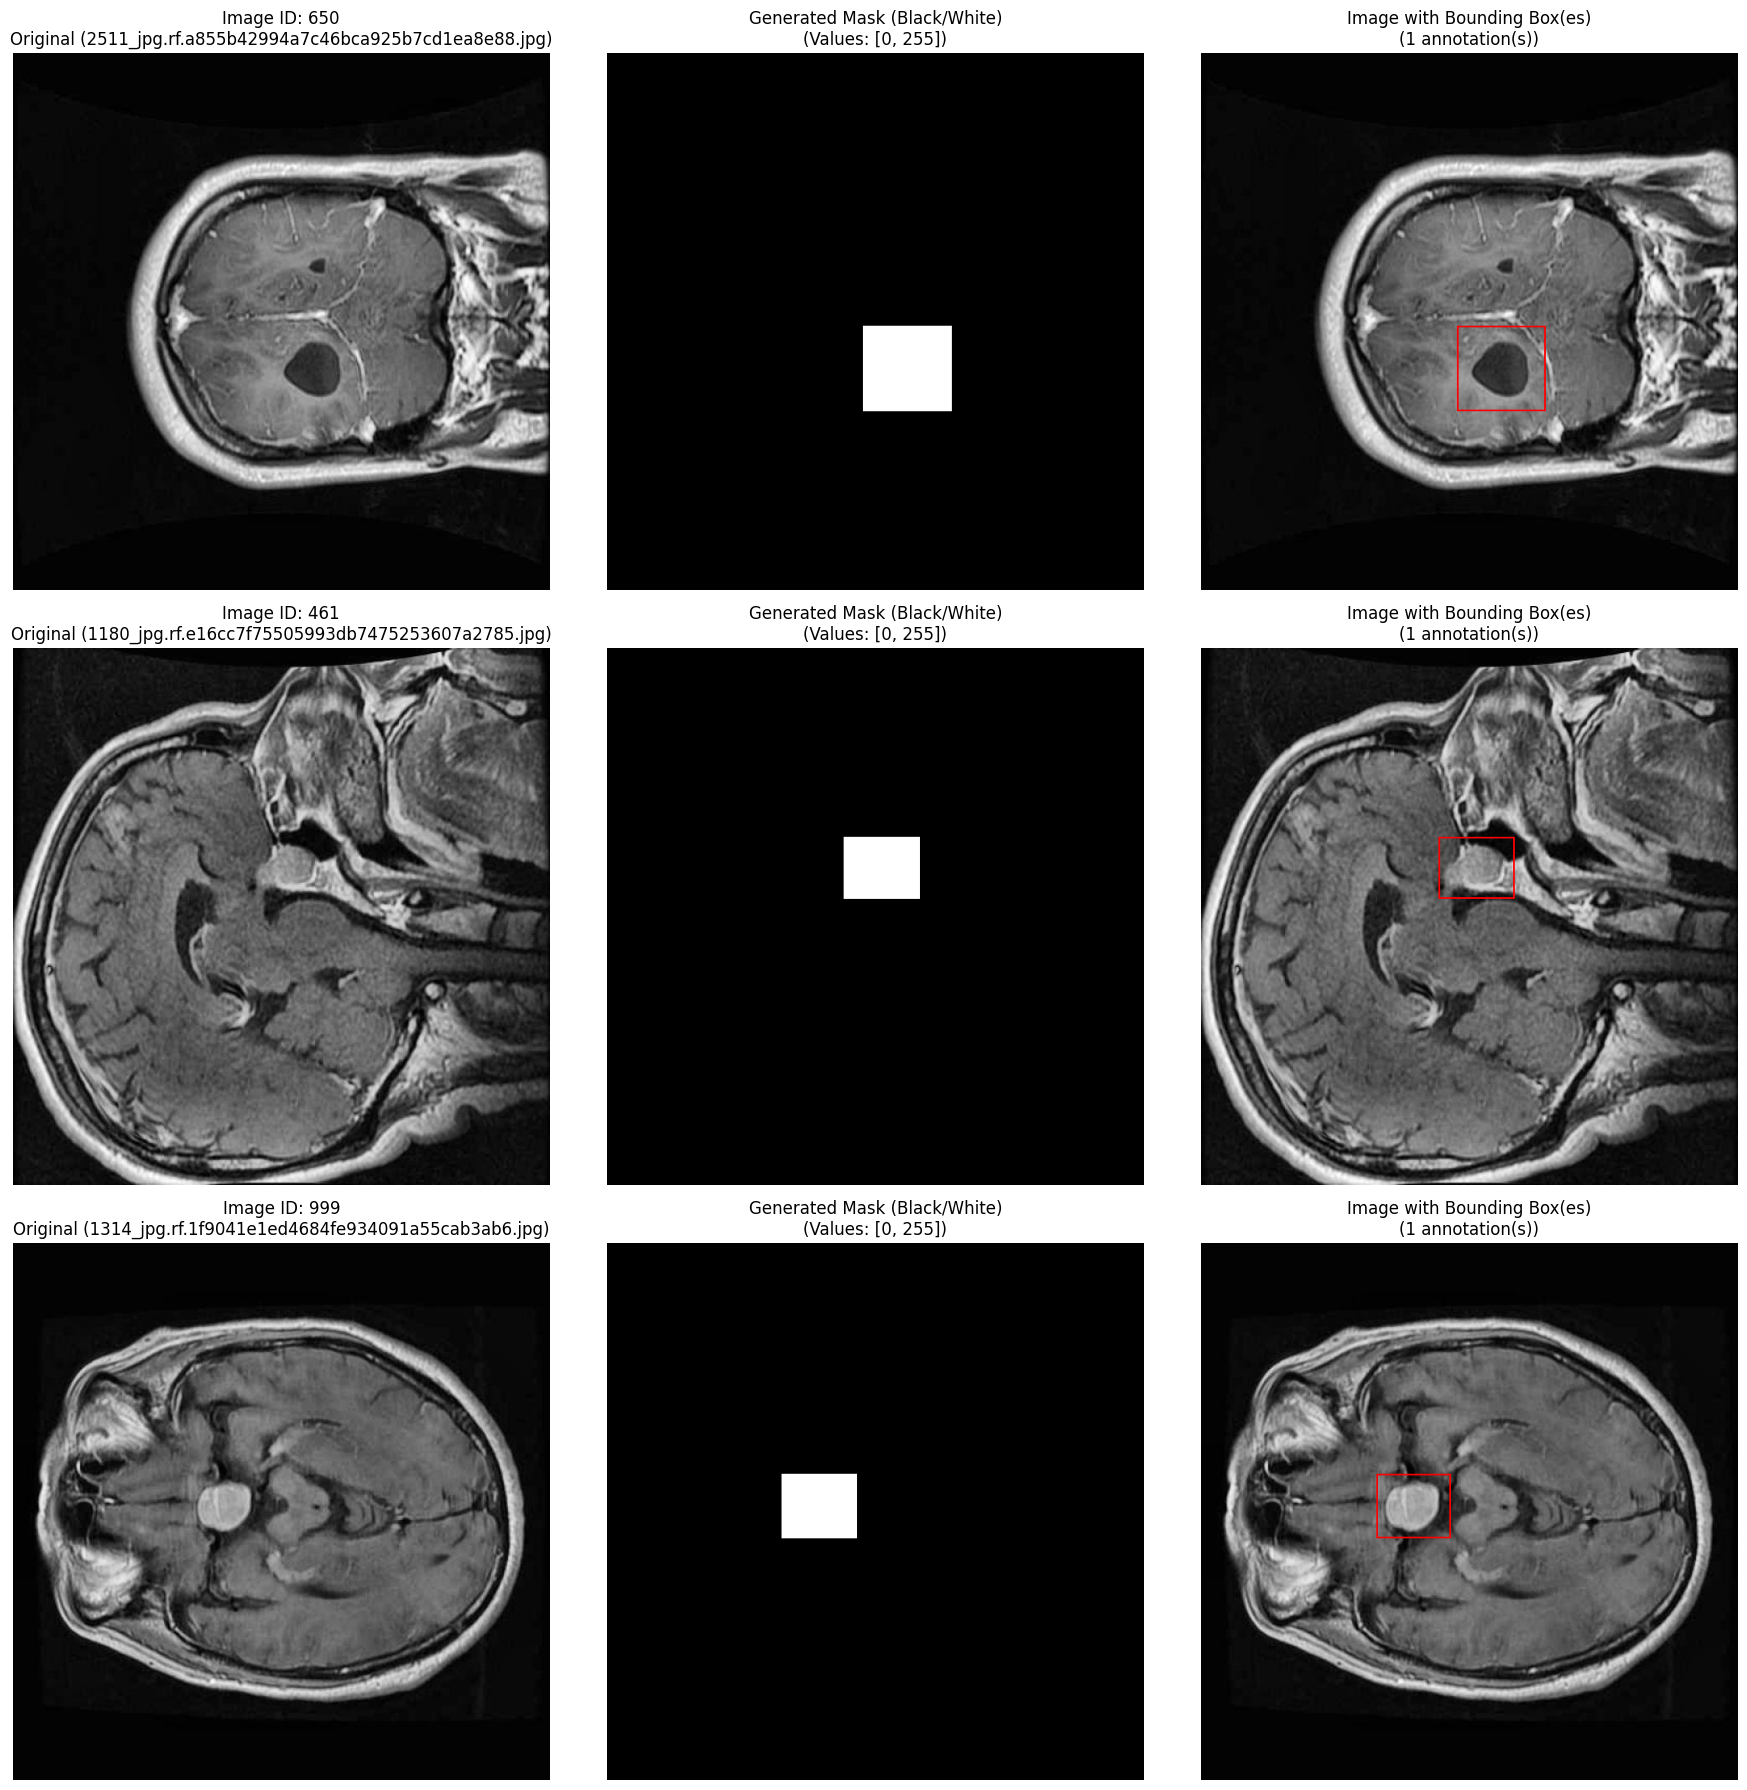

In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 匯入 PIL (Pillow) 函式庫，用於圖片處理
try:
    from PIL import Image, ImageDraw
    print("成功匯入 PIL (Pillow)。將使用 PIL 進行圖片處理。")
except ImportError:
    print("錯誤：無法匯入 PIL。無法繼續進行圖片處理。")
    raise

# --- 設定 ---
json_path = "./train/_annotations.coco.json"
image_base_dir = "./train"
num_samples_to_show = 3

print(f"--- 程式碼開始 ---")

try:
    # --- 1. 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        print("請上傳此檔案後再試一次。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")
        
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 2. 處理圖像和標註 ---
    all_image_ids = set()
    image_id_to_file = {}
    if 'images' in data:
        for img in data['images']:
            all_image_ids.add(img['id'])
            image_id_to_file[img['id']] = img['file_name']
    print(f"找到 {len(all_image_ids)} 張圖片的紀錄。")

    image_id_to_annotations = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            image_id_to_annotations[ann['image_id']].append(ann)
    print(f"找到 {len(image_id_to_annotations)} 張有標註的圖片。")

    # --- 3. 找出沒有標註的圖片 ---
    annotated_image_ids = set(image_id_to_annotations.keys())
    unannotated_image_ids = all_image_ids - annotated_image_ids
    
    print("\n--- 沒有標註的圖片 (Image IDs) ---")
    if unannotated_image_ids:
        print(f"共 {len(unannotated_image_ids)} 張:")
        print(list(unannotated_image_ids))
    else:
        print("所有圖片都有標註。")

    # --- 4. 找出有多個標註的圖片 ---
    multiple_annotated_image_ids = {img_id for img_id, annos in image_id_to_annotations.items() if len(annos) > 1}
            
    print("\n--- 有多個標註的圖片 (Image IDs) ---")
    if multiple_annotated_image_ids:
        print(f"共 {len(multiple_annotated_image_ids)} 張:")
        print(list(multiple_annotated_image_ids)[:50])
        if len(multiple_annotated_image_ids) > 50:
            print(f"... (還有 {len(multiple_annotated_image_ids) - 50} 個)")
    else:
        print("沒有圖片有多於一個標註。")

    # --- 5. 隨機挑選 {num_samples_to_show} 張有標註的圖片顯示 ---
    print(f"\n--- 隨機顯示 {num_samples_to_show} 張範例圖片 ---")
    
    annotated_image_id_list = list(annotated_image_ids)
    
    if not annotated_image_id_list:
        print("沒有可顯示的有標註圖片。")
    else:
        num_to_sample = min(num_samples_to_show, len(annotated_image_id_list))
        if num_to_sample < num_samples_to_show:
            print(f"警告：有標註的圖片少於 {num_samples_to_show} 張，僅顯示 {num_to_sample} 張。")
            
        sample_image_ids = random.sample(annotated_image_id_list, num_to_sample)
        print(f"將顯示 Image IDs: {sample_image_ids}")

        fig, axes = plt.subplots(num_to_sample, 3, figsize=(18, 6 * num_to_sample))
        if num_to_sample == 1:
            axes = np.array([axes])

        for i, sample_image_id in enumerate(sample_image_ids):
            try:
                file_name = image_id_to_file[sample_image_id]
                image_path = os.path.join(image_base_dir, file_name)
                
                if not os.path.exists(image_path):
                    print(f"錯誤：找不到圖片檔案 {image_path}")
                    axes[i, 0].set_title(f"Image ID {sample_image_id}\nFile Not Found: {file_name}", color='red')
                    axes[i, 0].axis('off')
                    axes[i, 1].axis('off')
                    axes[i, 2].axis('off')
                    continue

                # 使用 PIL 載入圖片
                image = Image.open(image_path).convert("RGB")
                
                # 準備 Mask (使用 PIL)
                # 'L' mode for 8-bit grayscale mask (0 = 黑色)
                mask_pil = Image.new("L", image.size, 0)
                mask_draw = ImageDraw.Draw(mask_pil)
                
                # 準備 Bounding Box 圖片 (使用 PIL)
                image_with_box = image.copy()
                box_draw = ImageDraw.Draw(image_with_box)
                
                mask_values = {0} # 0 代表背景 (黑色)
                
                annotations = image_id_to_annotations[sample_image_id]
                
                for ann in annotations:
                    # 繪製 Bounding Box
                    if 'bbox' in ann:
                        bbox = ann['bbox'] # [x, y, w, h]
                        x, y, w, h = map(int, bbox)
                        box_draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

                    # 繪製 Segmentation Mask
                    if 'segmentation' in ann:
                        segmentation = ann['segmentation']
                        for poly in segmentation:
                            # *** 修改：將 fill 改為 255 (白色) ***
                            mask_draw.polygon(poly, fill=255)
                        
                        if segmentation: # 如果真的有畫多邊形
                            # *** 將 mask value 記錄為 255 ***
                            mask_values.add(255)

                # --- 顯示 ---
                
                # 欄 1: 原始圖片
                ax = axes[i, 0]
                ax.imshow(image)
                ax.set_title(f"Image ID: {sample_image_id}\nOriginal ({file_name})")
                ax.axis('off')
                
                # 欄 2: 標註 Mask
                ax = axes[i, 1]
                # *** 使用 'gray' colormap 顯示黑白 ***
                ax.imshow(np.array(mask_pil), cmap='gray', vmin=0, vmax=255) 
                unique_values = sorted(list(mask_values))
                ax.set_title(f"Generated Mask (Black/White)\n(Values: {unique_values})")
                ax.axis('off')
                
                # 欄 3: Image with Bounding Box
                ax = axes[i, 2]
                ax.imshow(image_with_box)
                ax.set_title(f"Image with Bounding Box(es)\n({len(annotations)} annotation(s))")
                ax.axis('off')

            except FileNotFoundError:
                print(f"錯誤：在處理 ID {sample_image_id} 時找不到圖片檔案 {image_path}")
                axes[i, 0].set_title(f"Image ID {sample_image_id}\nFile Not Found: {file_name}", color='red')
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
            except Exception as e:
                print(f"處理 Image ID {sample_image_id} 時發生嚴重錯誤: {e}")
                axes[i, 0].set_title(f"Image ID {sample_image_id}\nError: {e}", color='red')
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
        
        plt.tight_layout()
        # 儲存為新檔名
        plt.savefig("annotation_analysis_samples_bw_mask.png")
        print("\n已儲存範例圖片至 annotation_analysis_samples_bw_mask.png")

except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
    print("請上傳此檔案以及範例圖片，然後重新執行。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("--- 程式碼執行完畢 ---")

成功匯入 PIL (Pillow)。
--- 程式碼開始 ---
將顯示 Image IDs: [1380, 1005]
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。

--- 正在處理 Image ID: 1380 ---
Image ID 1380 (2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg) 沒有標註。
已儲存圖片至 image_1380_original.png

--- 正在處理 Image ID: 1005 ---
Image ID 1005 (176_jpg.rf.23ef40c30986ba54b865d55a934bfa72.jpg) 有 2 個標註。
已儲存圖片至 image_1005_annotated.png

--- 程式碼執行完畢 ---


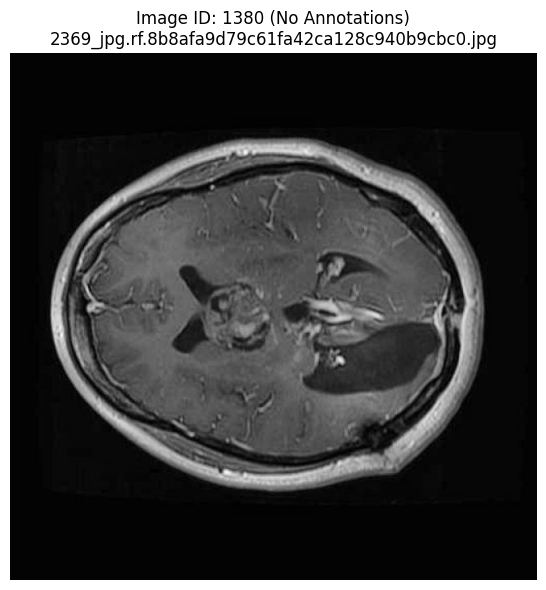

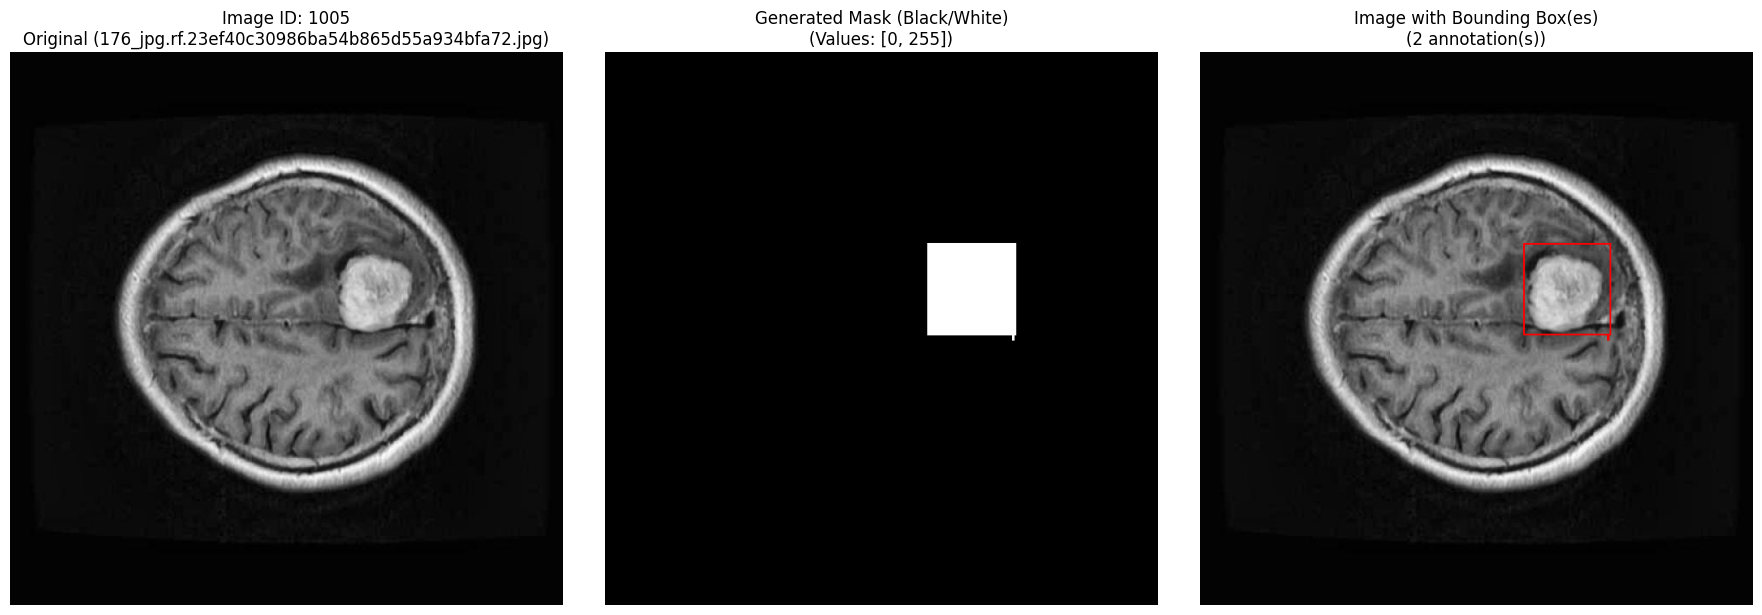

In [3]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 匯入 PIL (Pillow) 函式庫
try:
    from PIL import Image, ImageDraw
    print("成功匯入 PIL (Pillow)。")
except ImportError:
    print("錯誤：無法匯入 PIL。無法繼續進行圖片處理。")
    raise

# --- 設定 ---
json_path = "./train/_annotations.coco.json" # 從上次成功執行的路徑讀取
image_base_dir = "./train" # 從上次成功執行的路徑讀取
ids_to_display = [1380, 1005] # 指定要顯示的 Image IDs

print(f"--- 程式碼開始 ---")
print(f"將顯示 Image IDs: {ids_to_display}")

try:
    # --- 1. 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 2. 建立必要映射 ---
    image_id_to_file = {}
    if 'images' in data:
        for img in data['images']:
            image_id_to_file[img['id']] = img['file_name']

    image_id_to_annotations = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            image_id_to_annotations[ann['image_id']].append(ann)

    # --- 3. 顯示指定的圖片 ---
    for target_id in ids_to_display:
        print(f"\n--- 正在處理 Image ID: {target_id} ---")

        if target_id not in image_id_to_file:
            print(f"錯誤：在 JSON 的 'images' 中找不到 Image ID {target_id} 的紀錄。")
            continue

        file_name = image_id_to_file[target_id]
        image_path = os.path.join(image_base_dir, file_name)

        if not os.path.exists(image_path):
            print(f"錯誤：找不到圖片檔案 {image_path}")
            # 為此 ID 創建一個顯示錯誤的子圖
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.set_title(f"Image ID {target_id}\nFile Not Found: {file_name}", color='red')
            ax.axis('off')
            plt.savefig(f"image_{target_id}_error.png")
            print(f"已儲存錯誤訊息圖片至 image_{target_id}_error.png")
            continue

        try:
            # 使用 PIL 載入圖片
            image = Image.open(image_path).convert("RGB")
            annotations = image_id_to_annotations.get(target_id, []) # 使用 .get() 避免 ID 不存在時出錯

            if not annotations:
                # 如果沒有標註 (例如 ID 1380)
                print(f"Image ID {target_id} ({file_name}) 沒有標註。")
                fig, ax = plt.subplots(1, 1, figsize=(6, 6))
                ax.imshow(image)
                ax.set_title(f"Image ID: {target_id} (No Annotations)\n{file_name}")
                ax.axis('off')
                plt.tight_layout()
                plt.savefig(f"image_{target_id}_original.png")
                print(f"已儲存圖片至 image_{target_id}_original.png")
            else:
                # 如果有標註 (例如 ID 1005)
                print(f"Image ID {target_id} ({file_name}) 有 {len(annotations)} 個標註。")
                fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 顯示原圖、遮罩、邊界框

                # 準備 Mask (使用 PIL)
                mask_pil = Image.new("L", image.size, 0)
                mask_draw = ImageDraw.Draw(mask_pil)

                # 準備 Bounding Box 圖片 (使用 PIL)
                image_with_box = image.copy()
                box_draw = ImageDraw.Draw(image_with_box)

                mask_values = {0}

                for ann in annotations:
                    # 繪製 Bounding Box
                    if 'bbox' in ann:
                        bbox = ann['bbox']
                        x, y, w, h = map(int, bbox)
                        box_draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

                    # 繪製 Segmentation Mask (黑白)
                    if 'segmentation' in ann:
                        segmentation = ann['segmentation']
                        for poly in segmentation:
                            mask_draw.polygon(poly, fill=255)
                        if segmentation:
                            mask_values.add(255)

                # 顯示 - 欄 1: 原始圖片
                ax = axes[0]
                ax.imshow(image)
                ax.set_title(f"Image ID: {target_id}\nOriginal ({file_name})")
                ax.axis('off')

                # 顯示 - 欄 2: 標註 Mask (黑白)
                ax = axes[1]
                ax.imshow(np.array(mask_pil), cmap='gray', vmin=0, vmax=255)
                unique_values = sorted(list(mask_values))
                ax.set_title(f"Generated Mask (Black/White)\n(Values: {unique_values})")
                ax.axis('off')

                # 顯示 - 欄 3: Image with Bounding Box
                ax = axes[2]
                ax.imshow(image_with_box)
                ax.set_title(f"Image with Bounding Box(es)\n({len(annotations)} annotation(s))")
                ax.axis('off')

                plt.tight_layout()
                plt.savefig(f"image_{target_id}_annotated.png")
                print(f"已儲存圖片至 image_{target_id}_annotated.png")

        except Exception as e:
            print(f"處理 Image ID {target_id} 時發生錯誤: {e}")
            # 為此 ID 創建一個顯示錯誤的子圖
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.set_title(f"Image ID {target_id}\nError Processing: {e}", color='red')
            ax.axis('off')
            plt.savefig(f"image_{target_id}_error.png")
            print(f"已儲存錯誤訊息圖片至 image_{target_id}_error.png")


except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("\n--- 程式碼執行完畢 ---")

In [4]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 沿用之前的設定 ---
json_path = "./train/_annotations.coco.json"
image_base_dir = "./train"

print(f"--- 程式碼開始 ---")

try:
    # --- 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 記錄原始數量 ---
    original_image_count = len(data.get('images', []))
    original_annotation_count = len(data.get('annotations', []))
    print(f"原始圖片數量: {original_image_count}")
    print(f"原始標註數量: {original_annotation_count}")

    # --- 定義要移除的 ID 列表 ---
    # 這次包含上次的 1380 和這次的 1005
    image_ids_to_remove = {1380, 1005}
    print(f"\n正在移除 Image IDs {list(image_ids_to_remove)} 的紀錄...")

    # --- 移除指定的 Image IDs ---
    removed_image_count_total = 0
    removed_annotation_count_total = 0

    # 篩選 images 列表
    if 'images' in data:
        original_images = data['images']
        # 保留 ID 不在移除列表中的圖片
        data['images'] = [img for img in original_images if img.get('id') not in image_ids_to_remove]
        removed_image_count_total = original_image_count - len(data['images'])
        print(f"- 已從 'images' 移除 {removed_image_count_total} 筆紀錄。")

    # 篩選 annotations 列表
    if 'annotations' in data:
        original_annotations = data['annotations']
         # 保留 image_id 不在移除列表中的標註
        data['annotations'] = [ann for ann in original_annotations if ann.get('image_id') not in image_ids_to_remove]
        removed_annotation_count_total = original_annotation_count - len(data['annotations'])
        print(f"- 已從 'annotations' 移除 {removed_annotation_count_total} 筆紀錄。")

    # --- 記錄處理後數量 ---
    final_image_count = len(data.get('images', []))
    final_annotation_count = len(data.get('annotations', []))
    print(f"\n處理後圖片數量: {final_image_count}")
    print(f"處理後標註數量: {final_annotation_count}")

    # --- 重要提示 ---
    print("\n注意：上述移除操作僅在目前的程式記憶體中生效。")
    print("永久保存這個修改，將 'data' 變數寫入一個新的 JSON 檔案(./train/_annotations.coco.cleaned.json)。")
    # 例如:
    cleaned_json_path = "./train/_annotations.coco.cleaned.json"
    with open(cleaned_json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"已將清理後的資料儲存至 {cleaned_json_path}")


except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("\n--- 程式碼執行完畢 ---")

--- 程式碼開始 ---
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。
原始圖片數量: 1502
原始標註數量: 1502

正在移除 Image IDs [1380, 1005] 的紀錄...
- 已從 'images' 移除 2 筆紀錄。
- 已從 'annotations' 移除 2 筆紀錄。

處理後圖片數量: 1500
處理後標註數量: 1500

注意：上述移除操作僅在目前的程式記憶體中生效。
永久保存這個修改，將 'data' 變數寫入一個新的 JSON 檔案(./train/_annotations.coco.cleaned.json)。
已將清理後的資料儲存至 ./train/_annotations.coco.cleaned.json

--- 程式碼執行完畢 ---


### 資料清理 - 驗證集和測試集

將訓練集的清理操作應用到驗證集和測試集。


In [5]:
# ============================================================
# 資料清理 - 驗證集和測試集
# ============================================================
# 此 cell 對驗證集和測試集套用與訓練集相同的資料清理操作
# 移除有問題的圖片 ID: 1380 (無標註) 和 1005 (多重標註)

import json
import os

def clean_dataset(json_path, image_ids_to_remove, output_path):
    """
    清理資料集,移除指定的 image IDs
    
    參數:
        json_path: 原始 JSON 檔案路徑
        image_ids_to_remove: 要移除的 image ID 集合
        output_path: 輸出的清理後 JSON 檔案路徑
    
    返回:
        bool: 成功返回 True,失敗返回 False
    """
    print(f"\n{'='*60}")
    print(f"處理: {json_path}")
    print(f"{'='*60}")
    
    try:
        # 讀取 JSON 檔案
        if not os.path.exists(json_path):
            print(f"警告: 找不到檔案 '{json_path}',跳過處理。")
            return False
        
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        # 記錄原始數量
        original_image_count = len(data.get('images', []))
        original_annotation_count = len(data.get('annotations', []))
        print(f"原始: {original_image_count} 張圖片, {original_annotation_count} 個標註")
        
        # 過濾 images 列表
        if 'images' in data:
            data['images'] = [img for img in data['images'] 
                            if img.get('id') not in image_ids_to_remove]
            removed_images = original_image_count - len(data['images'])
        
        # 過濾 annotations 列表
        if 'annotations' in data:
            data['annotations'] = [ann for ann in data['annotations'] 
                                 if ann.get('image_id') not in image_ids_to_remove]
            removed_annotations = original_annotation_count - len(data['annotations'])
        
        # 記錄處理後數量
        final_image_count = len(data.get('images', []))
        final_annotation_count = len(data.get('annotations', []))
        
        print(f"移除: {removed_images} 張圖片, {removed_annotations} 個標註")
        print(f"剩餘: {final_image_count} 張圖片, {final_annotation_count} 個標註")
        
        # 儲存清理後的資料
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        print(f"✓ 已儲存至: {output_path}")
        
        return True
        
    except Exception as e:
        print(f"錯誤: {e}")
        return False

# ===== 主程式 =====
print("="*60)
print("開始清理驗證集和測試集")
print("="*60)

# 定義要移除的 ID (與訓練集相同)
image_ids_to_remove = {1380, 1005}
print(f"\n要移除的 Image IDs: {list(image_ids_to_remove)}")

# 處理驗證集
valid_success = clean_dataset(
    json_path="./valid/_annotations.coco.json",
    image_ids_to_remove=image_ids_to_remove,
    output_path="./valid/_annotations.coco.cleaned.json"
)

# 處理測試集
test_success = clean_dataset(
    json_path="./test/_annotations.coco.json",
    image_ids_to_remove=image_ids_to_remove,
    output_path="./test/_annotations.coco.cleaned.json"
)

# 總結
print("\n" + "="*60)
print("清理完成!")
print("="*60)
print(f"驗證集: {'✓ 成功' if valid_success else '✗ 失敗'}")
print(f"測試集: {'✓ 成功' if test_success else '✗ 失敗'}")
print("\n注意:")
print("- 清理後的檔案已儲存為 _annotations.coco.cleaned.json")
print("- 如需使用清理後的資料,請載入這些新檔案")
print("="*60)


開始清理驗證集和測試集

要移除的 Image IDs: [1380, 1005]

處理: ./valid/_annotations.coco.json
原始: 429 張圖片, 429 個標註
移除: 0 張圖片, 0 個標註
剩餘: 429 張圖片, 429 個標註
✓ 已儲存至: ./valid/_annotations.coco.cleaned.json

處理: ./test/_annotations.coco.json
原始: 215 張圖片, 215 個標註
移除: 0 張圖片, 0 個標註
剩餘: 215 張圖片, 215 個標註
✓ 已儲存至: ./test/_annotations.coco.cleaned.json

清理完成!
驗證集: ✓ 成功
測試集: ✓ 成功

注意:
- 清理後的檔案已儲存為 _annotations.coco.cleaned.json
- 如需使用清理後的資料,請載入這些新檔案


---
# Part 2: 模型訓練與評估
---

使用清理後的資料集進行 U-Net 模型的訓練和評估。


# 腦腫瘤影像分割專案

這是一個完整的深度學習專案，使用 U-Net 架構進行腦腫瘤 MRI 影像分割。

## 專案特色

- ✅ 完整的 U-Net 實作
- ✅ 資料增強（Albumentations）
- ✅ 組合損失函數（Dice + BCE）
- ✅ 完整的訓練與評估流程
- ✅ 視覺化功能
- ✅ Windows / GTX 960 優化設定

## 硬體需求

- **建議**: NVIDIA GPU (CUDA 支援)
- **本專案優化**: GTX 960 4GB
- **最低**: CPU（會很慢）

---

## 1. 環境設定 & 套件導入

首先設定環境變數解決 Windows 系統的相容性問題，並導入所有必要的套件。

In [6]:
# 解決 Windows 上的 OpenMP 衝突問題
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# PyTorch 相關
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

# 資料處理
import numpy as np
import cv2
from PIL import Image
import json
from pathlib import Path
from collections import defaultdict

# 視覺化
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# 資料增強
import albumentations as A
from albumentations.pytorch import ToTensorV2

print("套件導入成功！")

套件導入成功！


### GPU 檢查

檢查 CUDA 是否可用，以及 GPU 資訊。

In [7]:
# 檢查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用裝置: {device}")

if torch.cuda.is_available():
    print(f"GPU 名稱: {torch.cuda.get_device_name(0)}")
    print(f"GPU 數量: {torch.cuda.device_count()}")
    print(f"CUDA 版本: {torch.version.cuda}")
    print(f"顯存總量: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ CUDA 不可用，將使用 CPU（訓練會很慢）")

使用裝置: cuda
GPU 名稱: NVIDIA GeForce GTX 960
GPU 數量: 1
CUDA 版本: 12.1
顯存總量: 4.00 GB


## 2. 資料增強 & 預處理

使用 Albumentations 庫進行資料增強。訓練集使用多種增強技術，驗證集只進行基本的調整大小和正規化。

In [8]:
class TrainTransform:
    """訓練集的資料增強"""
    def __init__(self, image_size=640):
        self.transform = A.Compose([
            A.Resize(image_size, image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussianBlur(p=0.2),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ], is_check_shapes=False)
    
    def __call__(self, image, mask):
        transformed = self.transform(image=image, mask=mask)
        return transformed['image'], transformed['mask']


class ValidTransform:
    """驗證集/測試集的資料轉換（不增強）"""
    def __init__(self, image_size=640):
        self.transform = A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ], is_check_shapes=False)
    
    def __call__(self, image, mask):
        transformed = self.transform(image=image, mask=mask)
        return transformed['image'], transformed['mask']

print("資料增強類別定義完成！")

資料增強類別定義完成！


## 3. Dataset & DataLoader

自訂 Dataset 類別，從 COCO 格式的標註檔案載入影像和遮罩。

In [9]:
class BrainTumorDataset(Dataset):
    """腦腫瘤影像分割資料集"""
    
    def __init__(self, image_dir, annotation_file, transform=None):
        """
        Args:
            image_dir: 影像資料夾路徑
            annotation_file: COCO格式的annotation JSON檔案
            transform: 資料增強/轉換函數
        """
        self.image_dir = Path(image_dir)
        self.transform = transform
        
        # 載入COCO annotations
        with open(annotation_file, 'r', encoding='utf-8') as f:
            self.coco_data = json.load(f)
        
        # 建立image id到檔名的映射
        self.images = {img['id']: img for img in self.coco_data['images']}
        
        # 建立image id到annotations的映射
        self.image_to_anns = defaultdict(list)
        for ann in self.coco_data['annotations']:
            self.image_to_anns[ann['image_id']].append(ann)
        
        # 取得所有image ids
        self.image_ids = list(self.images.keys())
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # 取得image資訊
        image_id = self.image_ids[idx]
        image_info = self.images[image_id]
        
        # 載入影像
        image_path = self.image_dir / image_info['file_name']
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 建立mask
        height, width = image_info['height'], image_info['width']
        mask = self._create_mask(image_id, height, width)
        
        # 應用轉換
        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            # 如果沒有transform，至少轉成tensor
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        return image, mask
    
    def _create_mask(self, image_id, height, width):
        """從COCO segmentation建立binary mask"""
        mask = np.zeros((height, width), dtype=np.uint8)
        
        # 取得該影像的所有annotations
        annotations = self.image_to_anns[image_id]
        
        for ann in annotations:
            if 'segmentation' in ann:
                # COCO格式的segmentation可能是polygon或RLE
                if isinstance(ann['segmentation'], list):
                    # Polygon格式
                    for seg in ann['segmentation']:
                        poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                        cv2.fillPoly(mask, [poly], 1)
        
        return mask

print("Dataset 類別定義完成！")

Dataset 類別定義完成！


In [10]:
def create_dataloaders(train_dir, valid_dir, test_dir, 
                       train_ann, valid_ann, test_ann,
                       batch_size=8, num_workers=2):
    """建立訓練、驗證、測試的DataLoader"""
    
    # 建立datasets
    train_dataset = BrainTumorDataset(
        train_dir, train_ann, 
        transform=TrainTransform()
    )
    
    valid_dataset = BrainTumorDataset(
        valid_dir, valid_ann,
        transform=ValidTransform()
    )
    
    test_dataset = BrainTumorDataset(
        test_dir, test_ann,
        transform=ValidTransform()
    )
    
    # 建立dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, valid_loader, test_loader

print("DataLoader 工廠函數定義完成！")

DataLoader 工廠函數定義完成！


## 4. U-Net 模型架構

實作經典的 U-Net 架構用於影像分割。

In [11]:
class DoubleConv(nn.Module):
    """(Conv2D -> BatchNorm -> ReLU) * 2"""
    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """U-Net架構用於影像分割"""
    
    def __init__(self, in_channels=3, out_channels=1, features=[48, 96, 192, 384]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder (下採樣)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        
        # Decoder (上採樣)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))
        
        # 最終輸出層
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            # 處理尺寸不匹配的情況
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)
        
        return self.final_conv(x)

print("U-Net 模型定義完成！")

U-Net 模型定義完成！


### 測試模型創建

In [12]:
# 創建模型並測試
model = UNet(in_channels=3, out_channels=1)
model = model.to(device)

# 計算參數量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"總參數量: {total_params:,}")
print(f"可訓練參數量: {trainable_params:,}")

# 測試前向傳播
test_input = torch.randn(1, 3, 640, 640).to(device)
with torch.no_grad():
    output = model(test_input)
print(f"\n測試輸入形狀: {test_input.shape}")
print(f"測試輸出形狀: {output.shape}")
print("✓ 模型測試成功！")

總參數量: 17,465,809
可訓練參數量: 17,465,809

測試輸入形狀: torch.Size([1, 3, 640, 640])
測試輸出形狀: torch.Size([1, 1, 640, 640])
✓ 模型測試成功！


## 5. 損失函數

使用組合損失函數：Dice Loss + Binary Cross Entropy

In [13]:
class DiceLoss(nn.Module):
    """Dice Loss for segmentation"""
    
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        # 確保形狀匹配
        if pred.dim() == 4 and target.dim() == 3:
            target = target.unsqueeze(1)
        
        # 確保類型正確
        target = target.float()
        
        pred = torch.sigmoid(pred)
        
        # Flatten
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (
            pred.sum() + target.sum() + self.smooth
        )
        
        return 1 - dice


class CombinedLoss(nn.Module):
    """組合損失: Dice Loss + Binary Cross Entropy"""
    
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
    
    def forward(self, pred, target):
        # 確保 target 和 pred 的形狀匹配
        # pred: [B, 1, H, W], target可能是 [B, H, W] 或 [B, 1, H, W]
        if pred.dim() == 4 and target.dim() == 3:
            target = target.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]
        
        # 確保 target 是 float 類型
        target = target.float()
        
        dice = self.dice_loss(pred, target)
        bce = self.bce_loss(pred, target)
        return self.dice_weight * dice + self.bce_weight * bce

print("損失函數定義完成！")

損失函數定義完成！


## 6. 評估指標

定義 Dice 係數、IoU、Precision、Recall、F1 等評估指標。

In [14]:
def dice_coefficient(pred, target, threshold=0.5):
    """計算Dice係數"""
    # 確保形狀匹配
    if pred.dim() == 4 and target.dim() == 3:
        target = target.unsqueeze(1)
    
    # 確保類型正確
    target = target.float()
    
    pred = (torch.sigmoid(pred) > threshold).float()
    
    intersection = (pred * target).sum()
    dice = (2. * intersection) / (pred.sum() + target.sum() + 1e-8)
    
    return dice.item()


def iou_score(pred, target, threshold=0.5):
    """計算IoU (Intersection over Union)"""
    # 確保形狀匹配
    if pred.dim() == 4 and target.dim() == 3:
        target = target.unsqueeze(1)
    
    # 確保類型正確
    target = target.float()
    
    pred = (torch.sigmoid(pred) > threshold).float()
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = intersection / (union + 1e-8)
    
    return iou.item()


def calculate_metrics(pred, target, threshold=0.5):
    """計算所有評估指標"""
    # 確保形狀匹配
    if pred.dim() == 4 and target.dim() == 3:
        target = target.unsqueeze(1)
    
    # 確保類型正確
    target = target.float()
    
    pred_binary = (torch.sigmoid(pred) > threshold).float()
    
    # True Positives, False Positives, False Negatives
    tp = (pred_binary * target).sum().item()
    fp = (pred_binary * (1 - target)).sum().item()
    fn = ((1 - pred_binary) * target).sum().item()
    
    # Precision, Recall, F1
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    # Dice & IoU
    dice = dice_coefficient(pred, target, threshold)
    iou = iou_score(pred, target, threshold)
    
    return {
        'dice': dice,
        'iou': iou,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("評估指標函數定義完成！")

評估指標函數定義完成！


## 7. 訓練 & 驗證函數

包含 Early Stopping、訓練一個 epoch、驗證、完整訓練流程等功能。

In [15]:
class EarlyStopping:
    """Early Stopping來防止過擬合"""
    
    def __init__(self, patience=15, min_delta=0, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.mode == 'max':
            if score < self.best_score + self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0
        elif self.mode == 'min':
            if score > self.best_score - self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0

print("Early Stopping 定義完成！")

Early Stopping 定義完成！


In [16]:
# ========================================
# 混合精度訓練加速 (AMP)
# ========================================
from torch.cuda.amp import autocast, GradScaler

# 啟用混合精度
use_amp = torch.cuda.is_available()
scaler = GradScaler() if use_amp else None

print('=' * 60)
print(f'混合精度訓練 (AMP): {"✓ 啟用" if use_amp else "✗ 停用"}')
if use_amp:
    print('預期加速: 2-3x')
    print('記憶體節省: ~50%')
print('=' * 60)


混合精度訓練 (AMP): ✓ 啟用
預期加速: 2-3x
記憶體節省: ~50%


C:\Users\Kslab\AppData\Local\Temp\ipykernel_12724\340922298.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


In [17]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """訓練一個epoch"""
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    
    pbar = tqdm(loader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        # 前向傳播
        # 使用混合精度前向傳播
        with torch.amp.autocast('cuda', enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        # 反向傳播
        optimizer.zero_grad()
        # 混合精度反向傳播和優化
        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        
        # 計算指標
        dice = dice_coefficient(outputs, masks)
        
        running_loss += loss.item()
        running_dice += dice
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    
    return epoch_loss, epoch_dice


def validate(model, loader, criterion, device):
    """驗證"""
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)
            
        # 使用混合精度前向傳播
        with torch.amp.autocast('cuda', enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, masks)
            dice = dice_coefficient(outputs, masks)
            
            running_loss += loss.item()
            running_dice += dice
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}'
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    
    return epoch_loss, epoch_dice

print("訓練與驗證函數定義完成！")

訓練與驗證函數定義完成！


In [18]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, 
                scheduler, device, num_epochs=10, patience=15, 
                save_dir='./models'):
    """完整的訓練流程"""
    
    os.makedirs(save_dir, exist_ok=True)
    best_model_path = os.path.join(save_dir, 'best_model.pth')
    
    early_stopping = EarlyStopping(patience=patience, mode='max')
    
    history = {
        'train_loss': [],
        'train_dice': [],
        'valid_loss': [],
        'valid_dice': [],
        'lr': []
    }
    
    best_dice = 0.0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 50)
        
        # 訓練
        train_loss, train_dice = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # 驗證
        valid_loss, valid_dice = validate(
            model, valid_loader, criterion, device
        )
        
        # 學習率調整
        scheduler.step(valid_dice)
        current_lr = optimizer.param_groups[0]['lr']
        
        # 記錄
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['valid_loss'].append(valid_loss)
        history['valid_dice'].append(valid_dice)
        history['lr'].append(current_lr)
        
        print(f'Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Dice: {valid_dice:.4f}')
        print(f'Learning Rate: {current_lr:.6f}')
        
        # 儲存最佳模型
        if valid_dice > best_dice:
            best_dice = valid_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dice': best_dice,
            }, best_model_path)
            print(f'✓ Saved best model (Dice: {best_dice:.4f})')
        
        # Early Stopping
        early_stopping(valid_dice)
        if early_stopping.early_stop:
            print(f'\nEarly stopping triggered at epoch {epoch + 1}')
            break
    
    return history, best_dice

print("完整訓練流程函數定義完成！")

完整訓練流程函數定義完成！


## 8. 測試 & 視覺化

測試模型並視覺化預測結果。

In [19]:
def test_model(model, test_loader, device, save_dir='./results'):
    """在測試集上評估模型"""
    model.eval()
    
    all_metrics = []
    os.makedirs(save_dir, exist_ok=True)
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(tqdm(test_loader, desc='Testing')):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            metrics = calculate_metrics(outputs, masks)
            all_metrics.append(metrics)
    
    # 計算平均指標
    avg_metrics = {
        key: np.mean([m[key] for m in all_metrics])
        for key in all_metrics[0].keys()
    }
    
    return avg_metrics, all_metrics


def visualize_predictions(model, dataset, device, num_samples=5, save_path=None):
    """視覺化預測結果"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask = dataset[idx]
            
            # 預測
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            pred_mask = torch.sigmoid(output).cpu().squeeze().numpy()
            
            # 反正規化影像以供顯示
            image_np = image.cpu().numpy().transpose(1, 2, 0)
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            
            mask_np = mask.cpu().squeeze().numpy()
            
            # 畫圖
            axes[i, 0].imshow(image_np)
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_mask, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
            
            # Overlay
            axes[i, 3].imshow(image_np)
            axes[i, 3].imshow(pred_mask, cmap='jet', alpha=0.5)
            axes[i, 3].set_title('Overlay')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_training_history(history, save_path=None):
    """繪製訓練歷史"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss curve
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['valid_loss'], label='Valid Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Dice curve
    axes[1].plot(history['train_dice'], label='Train Dice')
    axes[1].plot(history['valid_dice'], label='Valid Dice')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Training and Validation Dice Score')
    axes[1].legend()
    axes[1].grid(True)
    
    # Learning rate
    axes[2].plot(history['lr'])
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].set_yscale('log')
    axes[2].grid(True)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

print("測試與視覺化函數定義完成！")

測試與視覺化函數定義完成！


## 9. 完整訓練範例

⚠️ **重要提醒**: 以下是完整的訓練流程範例。

### GTX 960 / Windows 系統優化設定

- `BATCH_SIZE = 1` - 最保守設定，避免 CUDA timeout
- `NUM_WORKERS = 0` - Windows 相容性
- 已設定 `KMP_DUPLICATE_LIB_OK=TRUE` 解決 OpenMP 衝突

### 訓練時間預估

使用 GTX 960 4GB:
- 每個 epoch: 約 8-12 小時
- 預計總時間: 5-15 天（視 Early Stopping 而定）

建議: 讓訓練在夜間運行，定期檢查進度。

In [20]:
# =============================================================================
# 設定參數
# =============================================================================

# 資料路徑
BASE_DIR = Path('.')
TRAIN_DIR = BASE_DIR / 'train'
VALID_DIR = BASE_DIR / 'valid'
TEST_DIR = BASE_DIR / 'test'

TRAIN_ANN = TRAIN_DIR / '_annotations.coco.cleaned.json'
VALID_ANN = VALID_DIR / '_annotations.coco.cleaned.json'
TEST_ANN = TEST_DIR / '_annotations.coco.cleaned.json'

# 訓練參數（GTX 960 優化設定）
BATCH_SIZE = 2       # 最保守設定，確保穩定訓練
NUM_EPOCHS = 100     # 最多訓練 100 輪
LEARNING_RATE = 1e-4 # 標準學習率
PATIENCE = 15        # Early Stopping 耐心值
NUM_WORKERS = 0      # Windows 系統建議設為 0

print("參數設定完成！")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Num Workers: {NUM_WORKERS}")
print(f"Device: {device}")

參數設定完成！
Batch Size: 2
Num Workers: 0
Device: cuda


In [21]:
# =============================================================================
# 載入資料
# =============================================================================

print('\n' + '='*50)
print('載入資料...')
print('='*50)

train_loader, valid_loader, test_loader = create_dataloaders(
    train_dir=TRAIN_DIR,
    valid_dir=VALID_DIR,
    test_dir=TEST_DIR,
    train_ann=TRAIN_ANN,
    valid_ann=VALID_ANN,
    test_ann=TEST_ANN,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

print(f'訓練集樣本數: {len(train_loader.dataset)}')
print(f'驗證集樣本數: {len(valid_loader.dataset)}')
print(f'測試集樣本數: {len(test_loader.dataset)}')


載入資料...
訓練集樣本數: 1500
驗證集樣本數: 429
測試集樣本數: 215


In [22]:
# =============================================================================
# 建立模型、損失函數、優化器
# =============================================================================

print('\n' + '='*50)
print('建立模型與訓練組件...')
print('='*50)

# 模型
model = UNet(in_channels=3, out_channels=1).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f'模型參數量: {total_params:,}')

# 損失函數
criterion = CombinedLoss(dice_weight=0.5, bce_weight=0.5)

# 優化器
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# 學習率調整器
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='max',
    patience=5,
    factor=0.5,
    verbose=True
)

print("訓練組件建立完成！")


建立模型與訓練組件...
模型參數量: 17,465,809
訓練組件建立完成！


c:\Users\Kslab\miniconda3\envs\brain_tumor\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
# =============================================================================
# 開始訓練
# =============================================================================

print('\n' + '='*50)
print('開始訓練...')
print('='*50)
print('⚠️ 訓練時間可能很長，請耐心等待！')
# print('⏱️ 預估每個 epoch 需要 8-12 小時\n')

# 執行訓練
history, best_dice = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    save_dir='./models'
)

print(f'\n✓ 訓練完成！最佳驗證 Dice Score: {best_dice:.4f}')


開始訓練...
⚠️ 訓練時間可能很長，請耐心等待！

Epoch 1/100
--------------------------------------------------


Training:   0%|          | 1/750 [00:40<8:30:49, 40.92s/it, loss=0.8383, dice=0.0613]


RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# =============================================================================
# 繪製訓練曲線
# =============================================================================

# 儲存訓練歷史
with open('results/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# 繪製訓練曲線
plot_training_history(history, save_path='results/training_curves.png')

In [ ]:
# =============================================================================
# 在測試集上評估
# =============================================================================

print('\n' + '='*50)
print('在測試集上評估...')
print('='*50)

# 載入最佳模型
checkpoint = torch.load('models/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# 測試
avg_metrics, all_metrics = test_model(model, test_loader, device, save_dir='./results')

print('\n測試集平均指標:')
print('-' * 30)
for key, value in avg_metrics.items():
    print(f'{key.capitalize():12s}: {value:.4f}')

# 儲存測試結果
with open('results/test_metrics.json', 'w') as f:
    json.dump({
        'average': avg_metrics,
        'all_samples': all_metrics
    }, f, indent=2)

In [ ]:
# =============================================================================
# 視覺化預測結果
# =============================================================================

print('\n' + '='*50)
print('產生預測視覺化...')
print('='*50)

test_dataset = BrainTumorDataset(
    TEST_DIR, 
    TEST_ANN,
    transform=ValidTransform()
)

visualize_predictions(
    model, 
    test_dataset, 
    device, 
    num_samples=5,
    save_path='results/predictions.png'
)

print('\n✓ 所有結果已儲存至 results/ 目錄')

## 10. 疑難排解 & 常見問題

### CUDA Timeout 錯誤

如果遇到 `CUDA error: the launch timed out and was terminated`:
- 降低 `BATCH_SIZE` (目前已是最小值 1)
- 減小 `image_size` (在 Transform 中調整，例如改為 512 或 448)
- 訓練時關閉其他應用程式

### DataLoader Worker 崩潰

Windows 系統常見問題：
- 確認 `NUM_WORKERS = 0`（目前已設定）

### OpenMP 錯誤

如果看到 `OMP: Error #15`:
- 確認已執行 `os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'`（notebook 開頭已設定）

### 記憶體不足

如果 GPU 顯存不足：
```python
# 降低批次大小（已經是 1，無法再降低）
# 降低影像解析度
TrainTransform(image_size=512)  # 或 448
```

### 訓練太慢

使用 GTX 960 4GB 確實會很慢，建議：
1. 降低影像解析度到 512 或 448
2. 使用雲端 GPU (Google Colab, Kaggle)
3. 讓訓練在夜間連續運行

### 檢查 GPU 使用

開新的終端執行：
```bash
nvidia-smi -l 1
```

確認：
- GPU 使用率接近 100%
- 顯存使用 < 4GB
- 溫度在 70-85°C 範圍

---

## 結語

這個 notebook 包含了完整的腦腫瘤分割專案程式碼，所有功能都已整合並優化。

**主要特色：**
- ✅ 完整的 U-Net 實作
- ✅ 所有問題修正（形狀、類型、Windows 相容性）
- ✅ GTX 960 優化設定
- ✅ 豐富的視覺化功能
- ✅ 詳細的說明文字

**祝訓練順利！** 🚀